<a href="https://colab.research.google.com/github/kiranash88/temp/blob/main/Mcap_TVL%20ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempting to load and clean data from 'ETH price vol market cap.xlsx'...
Market Cap and Price data from Excel loaded and cleaned successfully.
Fetching TVL data for 'Ethereum' from DefiLlama...

Data fetched successfully. Merging datasets...
Full calculation complete.

Filtering data to include dates from 2020-01-01 onwards...
Data filtered. New date range starts from: 2020-01-01

--- Generating Dual-Axis Plot: Ratio vs. Price ---


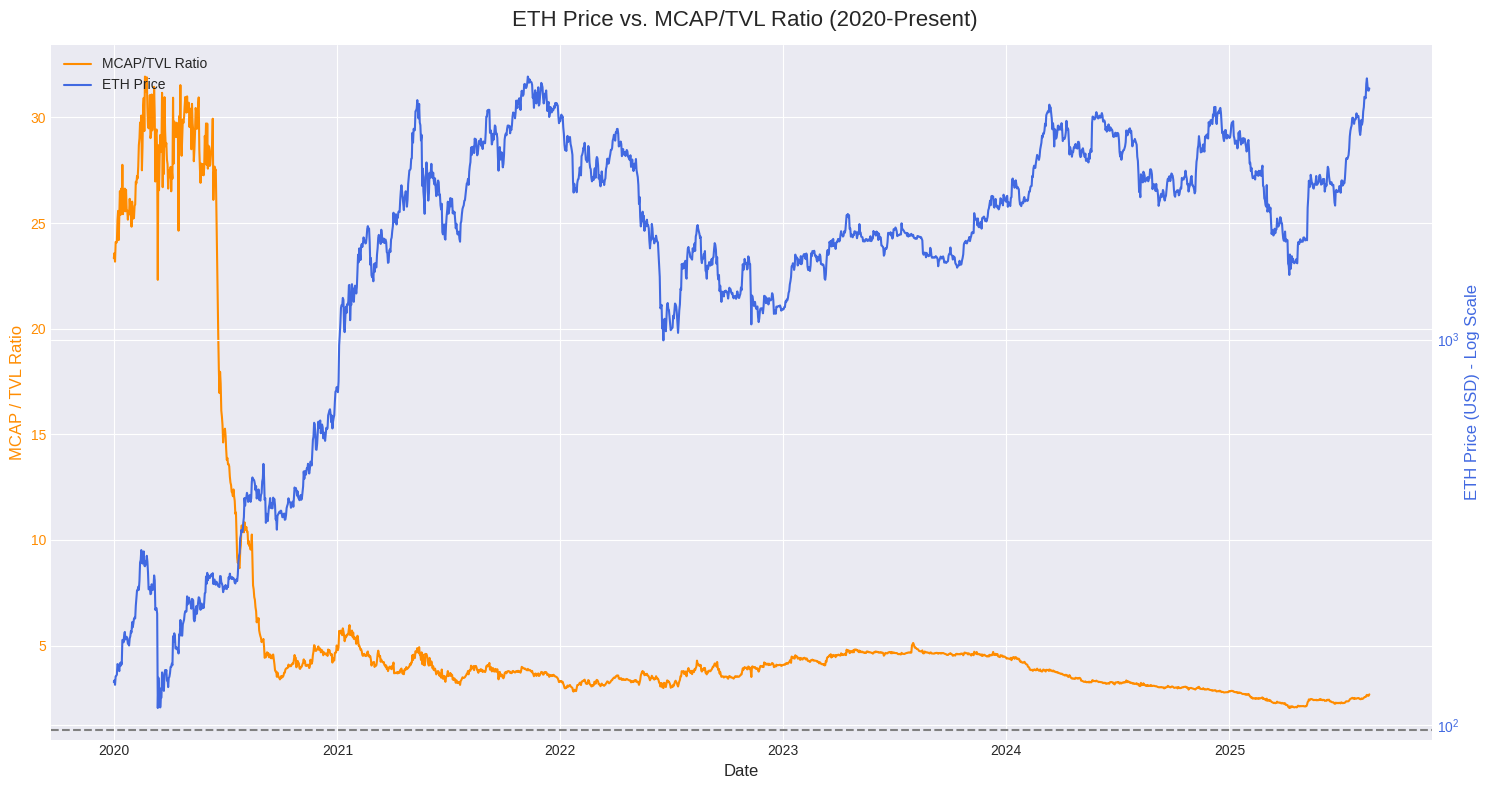


--- Performing Momentum Analysis ---
Hypothesis: Does the 7-day change in the ratio predict the next day's ETH return?

--- 2. Spearman's Rank Correlation Test ---
Spearman Correlation Coefficient: -0.0295
P-value: 0.1819
>> Interpretation: The p-value is not significant. No evidence of a monotonic relationship.

--- 3. Ordinary Least Squares (OLS) Linear Regression ---
                            OLS Regression Results                            
Dep. Variable:      eth_return_future   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.351
Date:                Tue, 19 Aug 2025   Prob (F-statistic):              0.245
Time:                        01:34:26   Log-Likelihood:                 3532.3
No. Observations:                2049   AIC:                            -7061.
Df Residuals:                    2047   BIC:                            -

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy import stats
import statsmodels.api as sm

# --- Configuration ---
excel_file_name = 'ETH price vol market cap.xlsx'

# --- Data Loading and Cleaning Functions (No changes here) ---

def get_mcap_from_excel(file_name: str):
    """
    Loads market cap and price data from the specified 'unstructured' Excel file,
    cleans it, and prepares it for analysis.
    """
    print(f"Attempting to load and clean data from '{file_name}'...")
    try:
        df_raw = pd.read_excel(file_name, header=None)
        column_headers = df_raw.iloc[0, 0].split(',')
        df_split = df_raw[0].str.split(',', expand=True)
        df_split.columns = column_headers
        df_cleaned = df_split.iloc[1:].reset_index(drop=True)
        df_final = df_cleaned[['snapped_at', 'price', 'market_cap']].copy()
        df_final['date'] = pd.to_datetime(df_final['snapped_at']).dt.tz_localize(None).dt.normalize()
        df_final['market_cap'] = pd.to_numeric(df_final['market_cap'])
        df_final['price'] = pd.to_numeric(df_final['price'])
        df_final.set_index('date', inplace=True)
        print("Market Cap and Price data from Excel loaded and cleaned successfully.")
        return df_final[['price', 'market_cap']]
    except FileNotFoundError:
        print(f"--- ERROR: File '{file_name}' not found. Please ensure it's uploaded to Colab. ---")
        return None
    except Exception as e:
        print(f"An error occurred while processing the Excel file: {e}")
        return None

def get_chain_tvl_data(chain_name: str):
    """Fetches historical TVL data from DefiLlama."""
    url = f"https://api.llama.fi/charts/{chain_name}"
    print(f"Fetching TVL data for '{chain_name}' from DefiLlama...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data)
        df.rename(columns={'date': 'timestamp', 'totalLiquidityUSD': 'tvl_usd'}, inplace=True)
        df['date'] = pd.to_datetime(df['timestamp'].astype(int), unit='s').dt.normalize()
        df.set_index('date', inplace=True)
        return df[['tvl_usd']]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching TVL data: {e}")
        return None

# --- NEW FUNCTION TO PLOT RATIO VS. PRICE ---
def plot_ratio_vs_price(df):
    """
    Plots the MCAP/TVL ratio against the ETH price on a dual-axis chart.
    """
    print("\n--- Generating Dual-Axis Plot: Ratio vs. Price ---")

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Plot 1: MCAP/TVL Ratio on the left axis (ax1)
    color1 = 'darkorange'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('MCAP / TVL Ratio', color=color1, fontsize=12)
    ax1.plot(df.index, df['mcap_tvl_ratio'], color=color1, label='MCAP/TVL Ratio')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.axhline(y=1.0, color='grey', linestyle='--', linewidth=1.5) # Parity line

    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()

    # Plot 2: ETH Price on the right axis (ax2)
    color2 = 'royalblue'
    ax2.set_ylabel('ETH Price (USD) - Log Scale', color=color2, fontsize=12)
    ax2.plot(df.index, df['price'], color=color2, label='ETH Price')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_yscale('log') # Use log scale for price

    # Final touches
    fig.suptitle('ETH Price vs. MCAP/TVL Ratio (2020-Present)', fontsize=16)
    fig.tight_layout() # Adjust layout to prevent labels from overlapping

    # Add a single legend for both lines
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()


def perform_change_analysis(df, lookback_period=7):
    """
    Tests if the change in MCAP/TVL ratio predicts future ETH returns.
    (This function is kept for completeness, no changes made)
    """
    print(f"\n--- Performing Momentum Analysis ---")
    print(f"Hypothesis: Does the {lookback_period}-day change in the ratio predict the next day's ETH return?")
    df_analysis = df.copy()
    df_analysis['ratio_change_pct'] = df_analysis['mcap_tvl_ratio'].pct_change(periods=lookback_period)
    df_analysis['eth_return_future'] = df_analysis['price'].pct_change().shift(-1)
    df_analysis.dropna(inplace=True)
    if df_analysis.empty:
        print(f"Not enough data to perform analysis with a lookback of {lookback_period} days.")
        return
    print("\n--- 2. Spearman's Rank Correlation Test ---")
    spearman_corr, spearman_p = stats.spearmanr(df_analysis['ratio_change_pct'], df_analysis['eth_return_future'])
    print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
    print(f"P-value: {spearman_p:.4f}")
    if spearman_p < 0.05:
        print(">> Interpretation: The p-value is significant. A monotonic relationship likely exists.")
    else:
        print(">> Interpretation: The p-value is not significant. No evidence of a monotonic relationship.")
    print("\n--- 3. Ordinary Least Squares (OLS) Linear Regression ---")
    X = df_analysis['ratio_change_pct']
    y = df_analysis['eth_return_future']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())

# --- Main execution block ---
if __name__ == '__main__':
    defi_llama_chain_name = "Ethereum"

    eth_data_df = get_mcap_from_excel(excel_file_name)
    tvl_df = get_chain_tvl_data(defi_llama_chain_name)

    if tvl_df is not None and eth_data_df is not None:
        print("\nData fetched successfully. Merging datasets...")

        df_merged = pd.merge(eth_data_df, tvl_df, left_index=True, right_index=True, how='inner')
        df_merged.dropna(inplace=True)
        df_merged = df_merged[df_merged['tvl_usd'] > 0]
        df_merged['mcap_tvl_ratio'] = df_merged['market_cap'] / df_merged['tvl_usd']

        print("Full calculation complete.")

        print("\nFiltering data to include dates from 2020-01-01 onwards...")
        df_2020_onwards = df_merged[df_merged.index >= '2020-01-01'].copy()

        print(f"Data filtered. New date range starts from: {df_2020_onwards.index.min().date()}")

        # --- Call the new plotting function ---
        plot_ratio_vs_price(df_2020_onwards)

        # --- We can still run the analysis after showing the plot ---
        perform_change_analysis(df_2020_onwards, lookback_period=7)

    else:
        print("\nCould not proceed with calculation due to data fetching errors.")


Data prepared. Analysis starts from: 2025-01-01
--- Starting Parameter Optimization ---
Total combinations to test: 77
  Testing combination 77/77: Lookback=30, Z-Score=3.2...

--- Optimization Complete ---
Top 5 Results (sorted by Sharpe Ratio):
    lookback  z_score  sharpe  return
59        28      2.6   2.747   0.733
66        29      2.6   2.744   0.507
73        30      2.6   2.438   0.429
58        28      2.4   2.172   0.678
74        30      2.8   1.960   0.163

--- Best Parameters Found ---
lookback    28.000
z_score      2.600
sharpe       2.747
return       0.733
Name: 59, dtype: float64

--- Running Final Backtest with Optimal Parameters and 0% Stop-Loss ---

--- Performance Summary ---
Strategy Total Return: 73.32%
Buy & Hold Total Return: 41.25%
Sharpe Ratio: 2.75

--- Trade Statistics ---
Total Closed Trades: 8
Winning Trades: 7
Losing Trades: 1
Win Rate: 87.50%

Successfully exported detailed trade log to 'detailed_trade_log.xlsx'

--- Detailed Trade Log (Console Disp

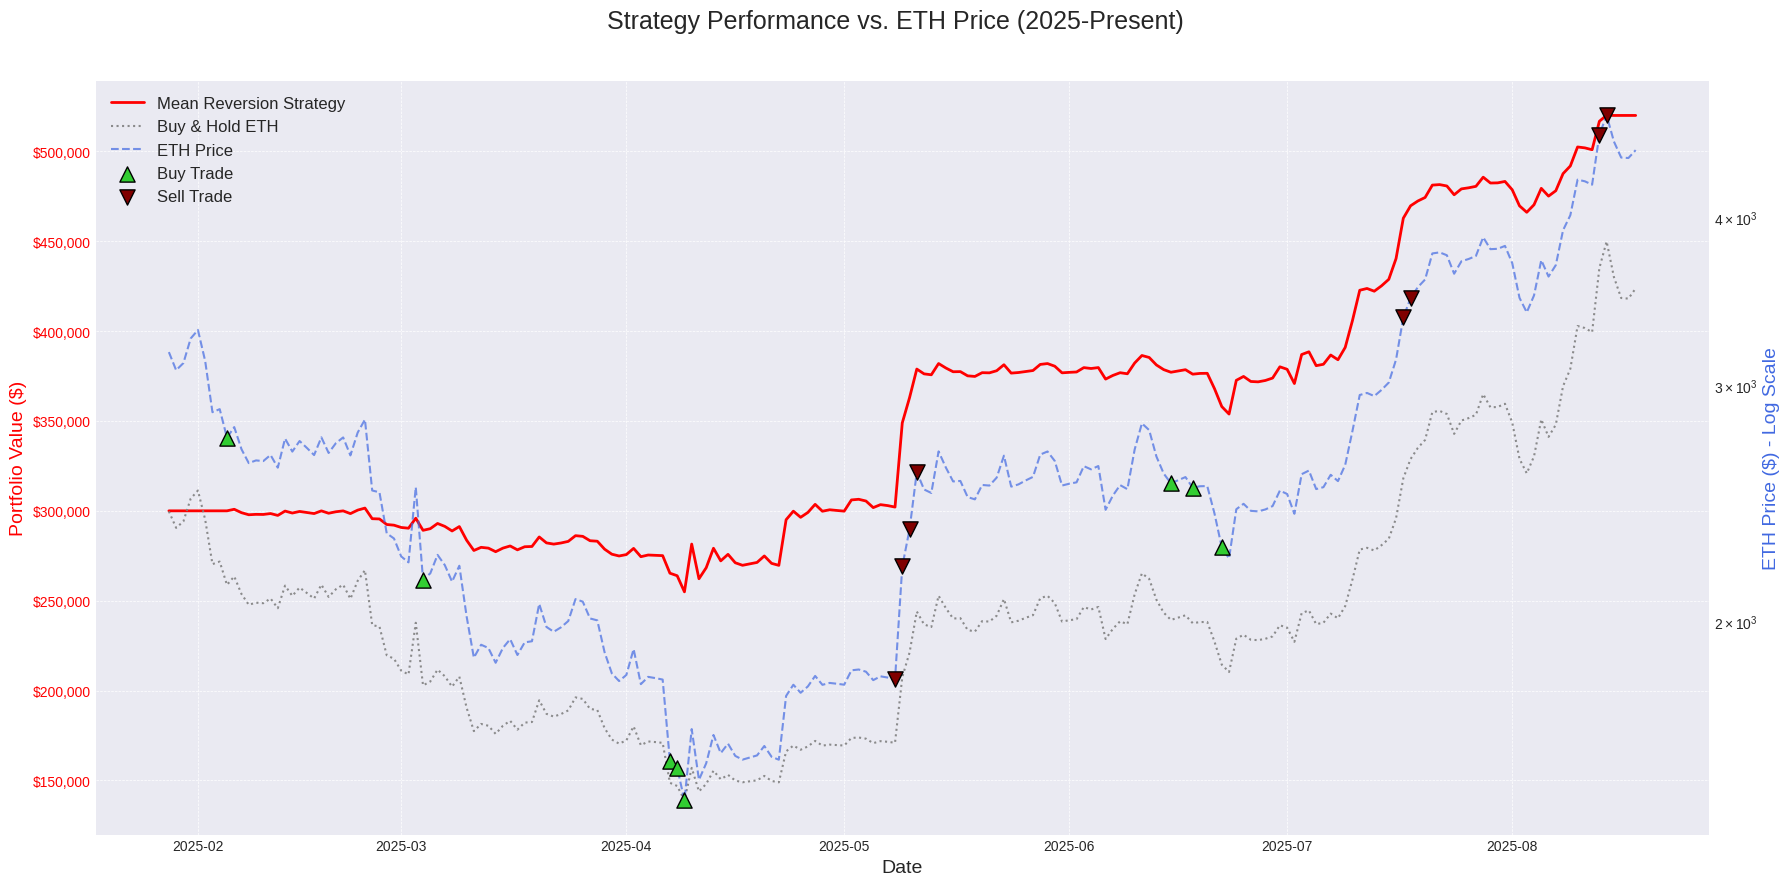

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- Data Loading Functions (Unchanged) ---
def get_mcap_from_excel(file_name: str):
    try:
        df_raw = pd.read_excel(file_name, header=None)
        column_headers = df_raw.iloc[0, 0].split(',')
        df_split = df_raw[0].str.split(',', expand=True)
        df_split.columns = column_headers
        df_cleaned = df_split.iloc[1:].reset_index(drop=True)
        df_final = df_cleaned[['snapped_at', 'price', 'market_cap']].copy()
        df_final['date'] = pd.to_datetime(df_final['snapped_at']).dt.tz_localize(None).dt.normalize()
        df_final['market_cap'] = pd.to_numeric(df_final['market_cap'])
        df_final['price'] = pd.to_numeric(df_final['price'])
        df_final.set_index('date', inplace=True)
        return df_final[['price', 'market_cap']]
    except Exception as e:
        print(f"An error occurred while processing the Excel file: {e}")
        return None

def get_chain_tvl_data(chain_name: str):
    url = f"https://api.llama.fi/charts/{chain_name}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data)
        df.rename(columns={'date': 'timestamp', 'totalLiquidityUSD': 'tvl_usd'}, inplace=True)
        df['date'] = pd.to_datetime(df['timestamp'].astype(int), unit='s').dt.normalize()
        df.set_index('date', inplace=True)
        return df[['tvl_usd']]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching TVL data: {e}")
        return None

# --- THE ENHANCED BACKTEST TEMPLATE CLASS ---
class BacktestTemplate:
    # --- MODIFIED: Added stop_loss_pct parameter ---
    def __init__(self, data, initial_capital, trade_amount, transaction_cost, stop_loss_pct=0):
        self.df = data.copy()
        self.initial_capital = initial_capital
        self.trade_amount = trade_amount
        self.transaction_cost = transaction_cost
        self.stop_loss_pct = stop_loss_pct # e.g., 0.10 for 10%

        # State variables
        self.cash = initial_capital
        self.positions = []
        self.trade_log = []
        self.portfolio_history = []
        self.closed_trades = []

    def _generate_signals(self, lookback_window, z_score_threshold):
        # (Unchanged)
        self.df['rolling_mean'] = self.df['mcap_tvl_ratio'].rolling(window=lookback_window).mean()
        self.df['rolling_std'] = self.df['mcap_tvl_ratio'].rolling(window=lookback_window).std()
        self.df['z_score'] = (self.df['mcap_tvl_ratio'] - self.df['rolling_mean']) / self.df['rolling_std']
        self.df['signal'] = 0
        self.df.loc[self.df['z_score'] < -z_score_threshold, 'signal'] = 1
        self.df.loc[self.df['z_score'] > z_score_threshold, 'signal'] = -1
        self.df.dropna(inplace=True)

    # --- MODIFIED: Integrated daily stop-loss check ---
    def run_backtest(self, lookback_window, z_score_threshold):
        self._generate_signals(lookback_window, z_score_threshold)

        for day, row in self.df.iterrows():
            current_price = row['price']

            # --- NEW: Daily Stop-Loss Check ---
            # We iterate over a copy of the list to safely remove items from the original.
            positions_to_keep = []
            for pos in self.positions:
                stop_price = pos['entry_price'] * (1 - self.stop_loss_pct)
                if self.stop_loss_pct > 0 and current_price <= stop_price:
                    # Stop-loss triggered, close position
                    gross_proceeds = pos['shares'] * current_price # Use current price for exit
                    exit_cost = gross_proceeds * self.transaction_cost
                    net_proceeds = gross_proceeds - exit_cost
                    pnl = net_proceeds - self.trade_amount
                    self.cash += net_proceeds
                    self.trade_log.append({'date': day, 'type': 'SELL', 'price': current_price})
                    self.closed_trades.append({
                        'entry_date': pos['entry_date'], 'exit_date': day,
                        'entry_price': pos['entry_price'], 'exit_price': current_price,
                        'shares': pos['shares'], 'pnl': pnl, 'exit_reason': 'STOP_LOSS' # New field
                    })
                else:
                    # Position is safe, keep it
                    positions_to_keep.append(pos)
            self.positions = positions_to_keep # Update the list of open positions

            # --- Portfolio valuation (after any stop-loss sales) ---
            current_position_value = sum(p['shares'] * current_price for p in self.positions)
            portfolio_value = self.cash + current_position_value
            self.portfolio_history.append({'date': day, 'value': portfolio_value})

            # --- Signal-based Trading Logic ---
            signal = row['signal']

            # BUY Logic (max_open_positions rule removed)
            if signal == 1 and self.cash >= self.trade_amount:
                cost = self.trade_amount * self.transaction_cost
                amount_invested = self.trade_amount - cost
                shares_bought = amount_invested / current_price
                self.cash -= self.trade_amount
                self.positions.append({'entry_date': day, 'entry_price': current_price, 'shares': shares_bought})
                self.trade_log.append({'date': day, 'type': 'BUY', 'price': current_price})

            # SELL Logic (FIFO)
            elif signal == -1 and self.positions:
                oldest_position = self.positions.pop(0)
                gross_proceeds = oldest_position['shares'] * current_price
                exit_cost = gross_proceeds * self.transaction_cost
                net_proceeds = gross_proceeds - exit_cost
                pnl = net_proceeds - self.trade_amount
                self.cash += net_proceeds
                self.trade_log.append({'date': day, 'type': 'SELL', 'price': current_price})
                self.closed_trades.append({
                    'entry_date': oldest_position['entry_date'], 'exit_date': day,
                    'entry_price': oldest_position['entry_price'], 'exit_price': current_price,
                    'shares': oldest_position['shares'], 'pnl': pnl, 'exit_reason': 'SIGNAL' # New field
                })

        return self.get_performance_metrics()

    # Other methods (get_performance_metrics, plot_results) are unchanged in their logic
    def get_performance_metrics(self):
        if not self.portfolio_history: return {}
        perf_df = pd.DataFrame(self.portfolio_history).set_index('date')
        perf_df['daily_return'] = perf_df['value'].pct_change()
        total_return_strat = (perf_df['value'].iloc[-1] / self.initial_capital - 1)
        sharpe_ratio_strat = (perf_df['daily_return'].mean() / perf_df['daily_return'].std()) * np.sqrt(365) if perf_df['daily_return'].std() != 0 else 0
        start_price = self.df['price'].iloc[0]
        end_price = self.df['price'].iloc[-1]
        bh_cost = self.initial_capital * self.transaction_cost
        bh_shares = (self.initial_capital - bh_cost) / start_price
        bh_final_value = bh_shares * end_price
        total_return_bh = (bh_final_value / self.initial_capital) - 1
        closed_trades_df = pd.DataFrame(self.closed_trades)
        total_trades = len(closed_trades_df)
        winning_trades = (closed_trades_df['pnl'] > 0).sum() if total_trades > 0 else 0
        losing_trades = total_trades - winning_trades
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
        return {'total_return_strategy': total_return_strat, 'total_return_bh': total_return_bh, 'sharpe_ratio': sharpe_ratio_strat, 'performance_df': perf_df, 'trade_log': pd.DataFrame(self.trade_log).set_index('date') if self.trade_log else pd.DataFrame(), 'closed_trades_df': closed_trades_df, 'total_trades': total_trades, 'winning_trades': winning_trades, 'losing_trades': losing_trades, 'win_rate': win_rate}
    def plot_results(self, performance_data):
        perf_df = performance_data['performance_df']
        trade_log = pd.DataFrame(self.trade_log)
        if not trade_log.empty:
            trade_log['date'] = pd.to_datetime(trade_log['date'])
            trade_log.set_index('date', inplace=True)
        if perf_df.empty: print("No performance data to plot."); return
        price_data = self.df[['price']].reindex(perf_df.index).ffill()
        bh_start_price = self.df['price'].loc[perf_df.index[0]]
        bh_shares = (self.initial_capital - (self.initial_capital * self.transaction_cost)) / bh_start_price
        bh_value_series = price_data['price'] * bh_shares
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax1 = plt.subplots(figsize=(18, 9))
        color1 = 'red'
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Portfolio Value ($)', color=color1, fontsize=14)
        ax1.plot(perf_df.index, perf_df['value'], label='Mean Reversion Strategy', color=color1, linewidth=2)
        ax1.plot(bh_value_series.index, bh_value_series, label='Buy & Hold ETH', color='gray', linestyle=':', alpha=0.9)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}'))
        ax2 = ax1.twinx()
        color2 = 'royalblue'
        ax2.set_ylabel('ETH Price ($) - Log Scale', color=color2, fontsize=14)
        ax2.plot(price_data.index, price_data['price'], label='ETH Price', color=color2, linestyle='--', alpha=0.7)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.set_yscale('log')
        ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}'))
        if not trade_log.empty:
            buys = trade_log[trade_log['type'] == 'BUY']
            sells = trade_log[trade_log['type'] == 'SELL']
            ax2.scatter(buys.index, buys['price'], marker='^', color='limegreen', s=120, label='Buy Trade', zorder=5, edgecolors='black')
            ax2.scatter(sells.index, sells['price'], marker='v', color='maroon', s=120, label='Sell Trade', zorder=5, edgecolors='black')
        fig.suptitle('Strategy Performance vs. ETH Price (2025-Present)', fontsize=18)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
        ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# --- Optimization Function (MODIFIED to accept stop_loss_pct) ---
def run_optimization(df, capital, trade_amt, cost, stop_loss, lookback_range, z_score_range):
    print("--- Starting Parameter Optimization ---")
    lookback_windows = np.arange(lookback_range[0], lookback_range[1] + 1, lookback_range[2])
    z_score_thresholds = np.arange(z_score_range[0], z_score_range[1] + z_score_range[2], z_score_range[2])
    param_grid = list(itertools.product(lookback_windows, z_score_thresholds))
    print(f"Total combinations to test: {len(param_grid)}")
    results = []

    for i, (lookback, z_score) in enumerate(param_grid):
        print(f"  Testing combination {i+1}/{len(param_grid)}: Lookback={lookback}, Z-Score={z_score:.1f}...", end='\r')
        engine = BacktestTemplate(df, capital, trade_amt, cost, stop_loss)
        metrics = engine.run_backtest(int(lookback), z_score)
        if metrics:
            results.append({'lookback': int(lookback), 'z_score': z_score, 'sharpe': metrics['sharpe_ratio'], 'return': metrics['total_return_strategy']})
    print("\n")
    results_df = pd.DataFrame(results)
    if results_df.empty or results_df['sharpe'].isnull().all():
        print("Warning: Could not find any valid results.")
        return None, None
    best_params = results_df.loc[results_df['sharpe'].idxmax()]
    print("--- Optimization Complete ---")
    print("Top 5 Results (sorted by Sharpe Ratio):")
    print(results_df.sort_values(by='sharpe', ascending=False).head().round(3))
    print("\n--- Best Parameters Found ---")
    print(best_params.round(3))
    return best_params['lookback'], best_params['z_score']

# --- Main Execution Block ---
if __name__ == '__main__':
    # --- CONFIGURATION ---
    INITIAL_CAPITAL = 300000
    FIXED_TRADE_AMOUNT = 50000
    TRANSACTION_COST = 0.001
    STOP_LOSS_PERCENTAGE = 0 # 10% stop-loss. Set to 0 to disable.

    eth_data_df = get_mcap_from_excel('ETH price vol market cap.xlsx')
    tvl_df = get_chain_tvl_data("Ethereum")

    if tvl_df is not None and eth_data_df is not None:
        df_merged = pd.merge(eth_data_df, tvl_df, left_index=True, right_index=True, how='inner')
        df_merged.dropna(inplace=True)
        df_merged = df_merged[df_merged['tvl_usd'] > 0]
        df_merged['mcap_tvl_ratio'] = df_merged['market_cap'] / df_merged['tvl_usd']
        df_2025_onwards = df_merged[df_merged.index >= '2025-01-01'].copy()
        print(f"\nData prepared. Analysis starts from: {df_2025_onwards.index.min().date()}")

        opt_lookback, opt_z_score = run_optimization(
            df=df_2025_onwards, capital=INITIAL_CAPITAL, trade_amt=FIXED_TRADE_AMOUNT,
            cost=TRANSACTION_COST, stop_loss=STOP_LOSS_PERCENTAGE,
            lookback_range=(20, 30, 1), z_score_range=(2.0, 3.0, 0.2)
        )

        if opt_lookback is not None and opt_z_score is not None:
            print(f"\n--- Running Final Backtest with Optimal Parameters and {STOP_LOSS_PERCENTAGE*100}% Stop-Loss ---")
            final_engine = BacktestTemplate(
                data=df_2025_onwards, initial_capital=INITIAL_CAPITAL,
                trade_amount=FIXED_TRADE_AMOUNT, transaction_cost=TRANSACTION_COST,
                stop_loss_pct=STOP_LOSS_PERCENTAGE
            )
            final_performance = final_engine.run_backtest(int(opt_lookback), opt_z_score)

            print("\n--- Performance Summary ---")
            print(f"Strategy Total Return: {final_performance.get('total_return_strategy', 0) * 100:.2f}%")
            print(f"Buy & Hold Total Return: {final_performance.get('total_return_bh', 0) * 100:.2f}%")
            print(f"Sharpe Ratio: {final_performance.get('sharpe_ratio', 0):.2f}")

            print("\n--- Trade Statistics ---")
            print(f"Total Closed Trades: {final_performance.get('total_trades', 0)}")
            print(f"Winning Trades: {final_performance.get('winning_trades', 0)}")
            print(f"Losing Trades: {final_performance.get('losing_trades', 0)}")
            print(f"Win Rate: {final_performance.get('win_rate', 0):.2f}%")

            closed_trades = final_performance.get('closed_trades_df')
            if closed_trades is not None and not closed_trades.empty:
                try:
                    excel_filename = 'detailed_trade_log.xlsx'
                    # --- MODIFIED: Ensure new column is in the export ---
                    export_cols = ['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl', 'exit_reason']
                    closed_trades.to_excel(excel_filename, index=False, columns=export_cols)
                    print(f"\nSuccessfully exported detailed trade log to '{excel_filename}'")
                except Exception as e:
                    print(f"\nError exporting to Excel: {e}")

                print("\n--- Detailed Trade Log (Console Display) ---")
                display_trades = closed_trades.copy()
                pd.set_option('display.max_rows', 100)
                display_trades['entry_date'] = display_trades['entry_date'].dt.strftime('%Y-%m-%d')
                display_trades['exit_date'] = display_trades['exit_date'].dt.strftime('%Y-%m-%d')
                display_trades['pnl'] = display_trades['pnl'].map('${:,.2f}'.format)
                display_trades['entry_price'] = display_trades['entry_price'].map('{:,.2f}'.format)
                display_trades['exit_price'] = display_trades['exit_price'].map('{:,.2f}'.format)
                print(display_trades[export_cols]) # Use the same columns for consistency

            final_engine.plot_results(final_performance)
        else:
            print("\nCould not run final backtest as no optimal parameters were determined.")
    else:
        print("\nCould not proceed due to data fetching errors.")


Data prepared for Solana. Analysis starts from: 2025-01-01
--- Starting Parameter Optimization ---
Total combinations to test: 6
  Testing combination 6/6: Lookback=8, Z-Score=1.8...

--- Optimization Complete ---
Top 5 Results (sorted by Sharpe Ratio):
   lookback  z_score  sharpe  return
2         7      1.8   1.396   0.196
4         8      1.6   1.054   0.299
1         7      1.6   0.907   0.235
5         8      1.8   0.877   0.171
3         8      1.4   0.791   0.204

--- Best Parameters Found ---
lookback    7.000
z_score     1.800
sharpe      1.396
return      0.196
Name: 2, dtype: float64

--- Running Final Backtest for SOL with Optimal Parameters and 0% Stop-Loss ---

--- Performance Summary ---
Strategy Total Return: 19.56%
Buy & Hold Total Return: -17.56%
Sharpe Ratio: 1.40
Maximum Drawdown: -12.07%

--- Trade Statistics ---
Total Closed Trades: 9
Winning Trades: 7
Losing Trades: 2
Win Rate: 77.78%

Successfully exported detailed trade log to 'detailed_trade_log_sol.xlsx'

-

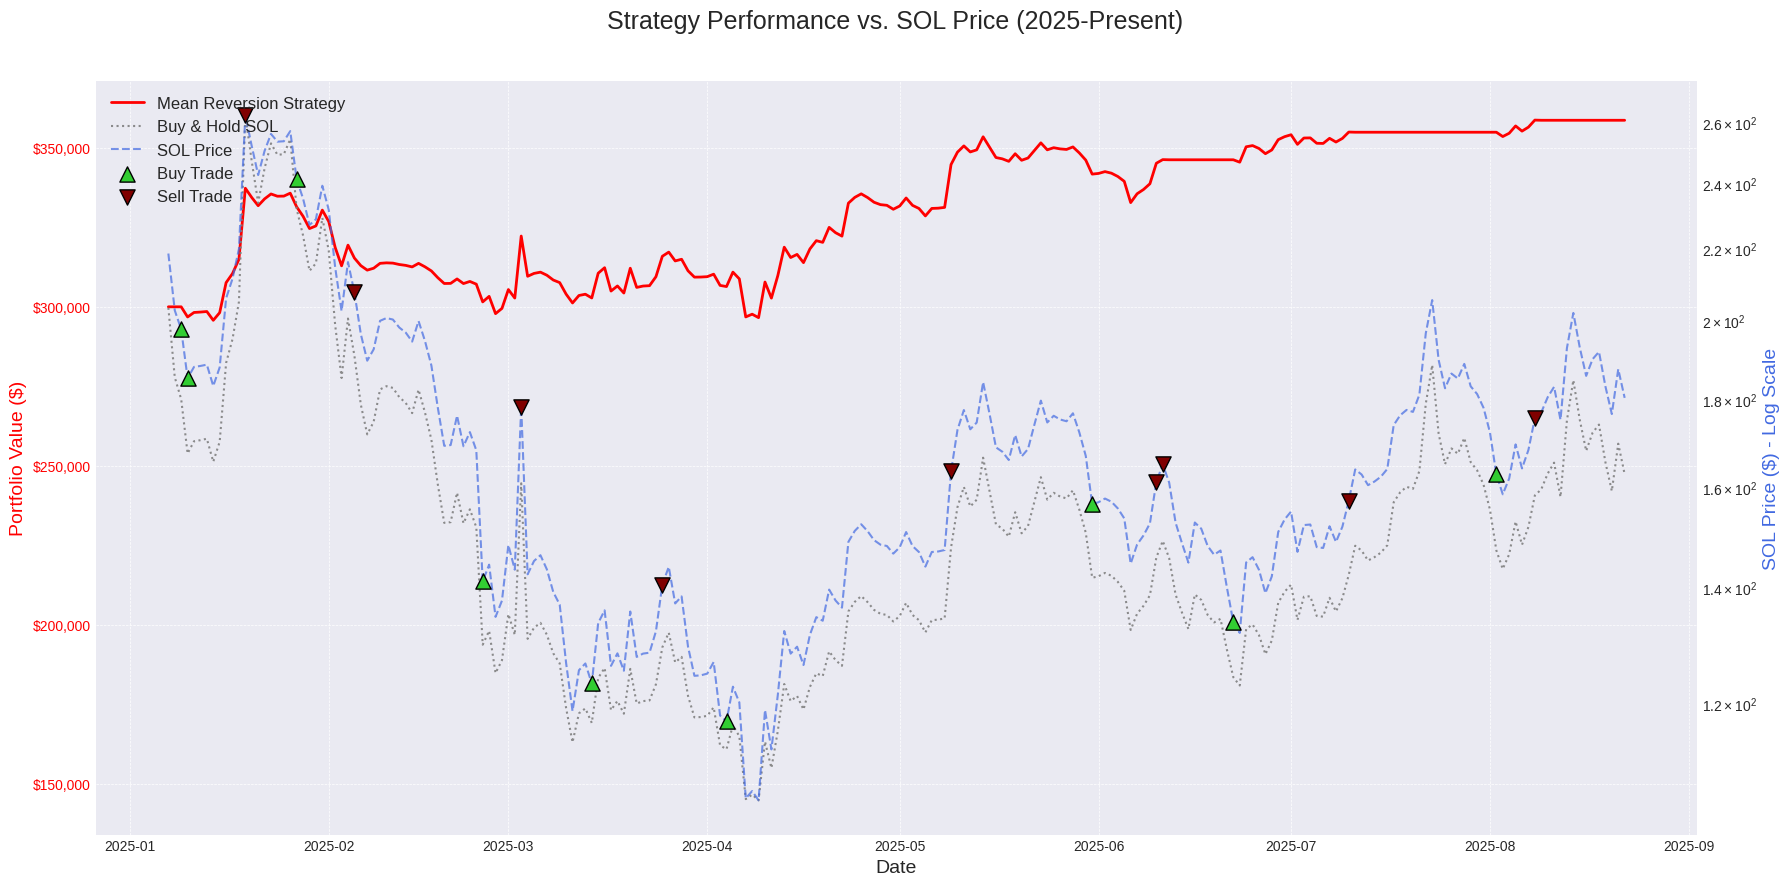

In [27]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- MODIFIED: Data Loading Function for the new Excel format ---
def get_mcap_from_excel(file_name: str):
    """
    Loads price and market cap data from the provided Excel file.
    This version is simplified to read directly from named columns.
    """
    try:
        # The header is now in the first row of the sheet, so we can read it directly.
        df = pd.read_excel(file_name)

        # Select and rename columns for consistency, if necessary
        df_final = df[['snapped_at', 'price', 'market_cap']].copy()

        # Convert data types
        df_final['date'] = pd.to_datetime(df_final['snapped_at']).dt.tz_localize(None).dt.normalize()
        df_final['market_cap'] = pd.to_numeric(df_final['market_cap'])
        df_final['price'] = pd.to_numeric(df_final['price'])

        # Set the date as the index
        df_final.set_index('date', inplace=True)

        return df_final[['price', 'market_cap']]
    except Exception as e:
        print(f"An error occurred while processing the Excel file: {e}")
        return None

# --- Data Loading Function for TVL (Unchanged) ---
def get_chain_tvl_data(chain_name: str):
    url = f"https://api.llama.fi/charts/{chain_name}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data)
        df.rename(columns={'date': 'timestamp', 'totalLiquidityUSD': 'tvl_usd'}, inplace=True)
        df['date'] = pd.to_datetime(df['timestamp'].astype(int), unit='s').dt.normalize()
        df.set_index('date', inplace=True)
        return df[['tvl_usd']]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching TVL data for {chain_name}: {e}")
        return None

# --- Backtest Template Class (Unchanged) ---
class BacktestTemplate:
    def __init__(self, data, initial_capital, trade_amount, transaction_cost, stop_loss_pct=0):
        self.df = data.copy()
        self.initial_capital = initial_capital
        self.trade_amount = trade_amount
        self.transaction_cost = transaction_cost
        self.stop_loss_pct = stop_loss_pct

        self.cash = initial_capital
        self.positions = []
        self.trade_log = []
        self.portfolio_history = []
        self.closed_trades = []
        self.z_score_threshold = 0

    def _generate_signals(self, lookback_window, z_score_threshold):
        self.df['rolling_mean'] = self.df['mcap_tvl_ratio'].rolling(window=lookback_window).mean()
        self.df['rolling_std'] = self.df['mcap_tvl_ratio'].rolling(window=lookback_window).std()
        self.df['z_score'] = (self.df['mcap_tvl_ratio'] - self.df['rolling_mean']) / self.df['rolling_std']
        self.df['signal'] = 0
        self.df.loc[self.df['z_score'] < -z_score_threshold, 'signal'] = 1
        self.df.loc[self.df['z_score'] > z_score_threshold, 'signal'] = -1
        self.df.dropna(inplace=True)

    def run_backtest(self, lookback_window, z_score_threshold):
        self._generate_signals(lookback_window, z_score_threshold)
        self.z_score_threshold = z_score_threshold

        for day, row in self.df.iterrows():
            current_price = row['price']
            current_z_score = row['z_score']

            positions_to_keep = []
            for pos in self.positions:
                stop_price = pos['entry_price'] * (1 - self.stop_loss_pct)
                if self.stop_loss_pct > 0 and current_price <= stop_price:
                    gross_proceeds = pos['shares'] * current_price
                    exit_cost = gross_proceeds * self.transaction_cost
                    net_proceeds = gross_proceeds - exit_cost
                    pnl = net_proceeds - self.trade_amount
                    self.cash += net_proceeds
                    self.trade_log.append({'date': day, 'type': 'SELL', 'price': current_price})
                    self.closed_trades.append({
                        'entry_date': pos['entry_date'], 'exit_date': day,
                        'entry_price': pos['entry_price'], 'exit_price': current_price,
                        'shares': pos['shares'], 'pnl': pnl, 'exit_reason': 'STOP_LOSS',
                        'entry_z_score': pos['entry_z_score'],
                        'exit_z_score': current_z_score,
                        'z_score_threshold': self.z_score_threshold
                    })
                else:
                    positions_to_keep.append(pos)
            self.positions = positions_to_keep

            current_position_value = sum(p['shares'] * current_price for p in self.positions)
            portfolio_value = self.cash + current_position_value
            self.portfolio_history.append({'date': day, 'value': portfolio_value})

            signal = row['signal']

            if signal == 1 and self.cash >= self.trade_amount:
                cost = self.trade_amount * self.transaction_cost
                amount_invested = self.trade_amount - cost
                shares_bought = amount_invested / current_price
                self.cash -= self.trade_amount
                self.positions.append({
                    'entry_date': day, 'entry_price': current_price,
                    'shares': shares_bought, 'entry_z_score': current_z_score
                })
                self.trade_log.append({'date': day, 'type': 'BUY', 'price': current_price})

            elif signal == -1 and self.positions:
                oldest_position = self.positions.pop(0)
                gross_proceeds = oldest_position['shares'] * current_price
                exit_cost = gross_proceeds * self.transaction_cost
                net_proceeds = gross_proceeds - exit_cost
                pnl = net_proceeds - self.trade_amount
                self.cash += net_proceeds
                self.trade_log.append({'date': day, 'type': 'SELL', 'price': current_price})
                self.closed_trades.append({
                    'entry_date': oldest_position['entry_date'], 'exit_date': day,
                    'entry_price': oldest_position['entry_price'], 'exit_price': current_price,
                    'shares': oldest_position['shares'], 'pnl': pnl, 'exit_reason': 'SIGNAL',
                    'entry_z_score': oldest_position['entry_z_score'],
                    'exit_z_score': current_z_score,
                    'z_score_threshold': self.z_score_threshold
                })

        return self.get_performance_metrics()

    def get_performance_metrics(self):
        if not self.portfolio_history: return {}
        perf_df = pd.DataFrame(self.portfolio_history).set_index('date')
        perf_df['daily_return'] = perf_df['value'].pct_change()
        running_peak = perf_df['value'].cummax()
        drawdown = (perf_df['value'] - running_peak) / running_peak
        max_drawdown = drawdown.min() if not drawdown.empty else 0
        total_return_strat = (perf_df['value'].iloc[-1] / self.initial_capital - 1)
        sharpe_ratio_strat = (perf_df['daily_return'].mean() / perf_df['daily_return'].std()) * np.sqrt(365) if perf_df['daily_return'].std() != 0 else 0
        start_price = self.df['price'].iloc[0]
        end_price = self.df['price'].iloc[-1]
        bh_cost = self.initial_capital * self.transaction_cost
        bh_shares = (self.initial_capital - bh_cost) / start_price
        bh_final_value = bh_shares * end_price
        total_return_bh = (bh_final_value / self.initial_capital) - 1
        closed_trades_df = pd.DataFrame(self.closed_trades)
        total_trades = len(closed_trades_df)
        winning_trades = (closed_trades_df['pnl'] > 0).sum() if total_trades > 0 else 0
        losing_trades = total_trades - winning_trades
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
        return {'total_return_strategy': total_return_strat, 'total_return_bh': total_return_bh, 'sharpe_ratio': sharpe_ratio_strat, 'max_drawdown': max_drawdown, 'performance_df': perf_df, 'trade_log': pd.DataFrame(self.trade_log).set_index('date') if self.trade_log else pd.DataFrame(), 'closed_trades_df': closed_trades_df, 'total_trades': total_trades, 'winning_trades': winning_trades, 'losing_trades': losing_trades, 'win_rate': win_rate}

    # --- MODIFIED: Plot labels updated for SOL ---
    def plot_results(self, performance_data):
        perf_df = performance_data['performance_df']
        trade_log = pd.DataFrame(self.trade_log)
        if not trade_log.empty:
            trade_log['date'] = pd.to_datetime(trade_log['date'])
            trade_log.set_index('date', inplace=True)
        if perf_df.empty: print("No performance data to plot."); return
        price_data = self.df[['price']].reindex(perf_df.index).ffill()
        bh_start_price = self.df['price'].loc[perf_df.index[0]]
        bh_shares = (self.initial_capital - (self.initial_capital * self.transaction_cost)) / bh_start_price
        bh_value_series = price_data['price'] * bh_shares
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax1 = plt.subplots(figsize=(18, 9))
        color1 = 'red'
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Portfolio Value ($)', color=color1, fontsize=14)
        ax1.plot(perf_df.index, perf_df['value'], label='Mean Reversion Strategy', color=color1, linewidth=2)
        ax1.plot(bh_value_series.index, bh_value_series, label='Buy & Hold SOL', color='gray', linestyle=':', alpha=0.9)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}'))
        ax2 = ax1.twinx()
        color2 = 'royalblue'
        ax2.set_ylabel('SOL Price ($) - Log Scale', color=color2, fontsize=14)
        ax2.plot(price_data.index, price_data['price'], label='SOL Price', color=color2, linestyle='--', alpha=0.7)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.set_yscale('log')
        ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}'))
        if not trade_log.empty:
            buys = trade_log[trade_log['type'] == 'BUY']
            sells = trade_log[trade_log['type'] == 'SELL']
            ax2.scatter(buys.index, buys['price'], marker='^', color='limegreen', s=120, label='Buy Trade', zorder=5, edgecolors='black')
            ax2.scatter(sells.index, sells['price'], marker='v', color='maroon', s=120, label='Sell Trade', zorder=5, edgecolors='black')
        fig.suptitle('Strategy Performance vs. SOL Price (2025-Present)', fontsize=18)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
        ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# --- Optimization Function (Unchanged) ---
def run_optimization(df, capital, trade_amt, cost, stop_loss, lookback_range, z_score_range):
    print("--- Starting Parameter Optimization ---")
    lookback_windows = np.arange(lookback_range[0], lookback_range[1] + 1, lookback_range[2])
    z_score_thresholds = np.arange(z_score_range[0], z_score_range[1] + z_score_range[2], z_score_range[2])
    param_grid = list(itertools.product(lookback_windows, z_score_thresholds))
    print(f"Total combinations to test: {len(param_grid)}")
    results = []

    for i, (lookback, z_score) in enumerate(param_grid):
        print(f"  Testing combination {i+1}/{len(param_grid)}: Lookback={lookback}, Z-Score={z_score:.1f}...", end='\r')
        engine = BacktestTemplate(df, capital, trade_amt, cost, stop_loss)
        metrics = engine.run_backtest(int(lookback), z_score)
        if metrics:
            results.append({'lookback': int(lookback), 'z_score': z_score, 'sharpe': metrics['sharpe_ratio'], 'return': metrics['total_return_strategy']})
    print("\n")
    results_df = pd.DataFrame(results)
    if results_df.empty or results_df['sharpe'].isnull().all():
        print("Warning: Could not find any valid results.")
        return None, None
    best_params = results_df.loc[results_df['sharpe'].idxmax()]
    print("--- Optimization Complete ---")
    print("Top 5 Results (sorted by Sharpe Ratio):")
    print(results_df.sort_values(by='sharpe', ascending=False).head().round(3))
    print("\n--- Best Parameters Found ---")
    print(best_params.round(3))
    return best_params['lookback'], best_params['z_score']

# --- MODIFIED: Main Execution Block for SOL ---
if __name__ == '__main__':
    INITIAL_CAPITAL = 300000
    FIXED_TRADE_AMOUNT = 50000
    TRANSACTION_COST = 0.001
    STOP_LOSS_PERCENTAGE = 0

    # Load data for Solana
    sol_data_df = get_mcap_from_excel('SOL price vol market cap.xlsx')
    tvl_df = get_chain_tvl_data("Solana")

    if tvl_df is not None and sol_data_df is not None:
        df_merged = pd.merge(sol_data_df, tvl_df, left_index=True, right_index=True, how='inner')
        df_merged.dropna(inplace=True)
        df_merged = df_merged[df_merged['tvl_usd'] > 0]
        df_merged['mcap_tvl_ratio'] = df_merged['market_cap'] / df_merged['tvl_usd']
        df_2025_onwards = df_merged[df_merged.index >= '2025-01-01'].copy()
        print(f"\nData prepared for Solana. Analysis starts from: {df_2025_onwards.index.min().date()}")

        opt_lookback, opt_z_score = run_optimization(
            df=df_2025_onwards, capital=INITIAL_CAPITAL, trade_amt=FIXED_TRADE_AMOUNT,
            cost=TRANSACTION_COST, stop_loss=STOP_LOSS_PERCENTAGE,
            lookback_range=(7, 8, 1), z_score_range=(1.4, 1.6, 0.2)
        )

        if opt_lookback is not None and opt_z_score is not None:
            print(f"\n--- Running Final Backtest for SOL with Optimal Parameters and {STOP_LOSS_PERCENTAGE*100}% Stop-Loss ---")
            final_engine = BacktestTemplate(
                data=df_2025_onwards, initial_capital=INITIAL_CAPITAL,
                trade_amount=FIXED_TRADE_AMOUNT, transaction_cost=TRANSACTION_COST,
                stop_loss_pct=STOP_LOSS_PERCENTAGE
            )
            final_performance = final_engine.run_backtest(int(opt_lookback), opt_z_score)

            print("\n--- Performance Summary ---")
            print(f"Strategy Total Return: {final_performance.get('total_return_strategy', 0) * 100:.2f}%")
            print(f"Buy & Hold Total Return: {final_performance.get('total_return_bh', 0) * 100:.2f}%")
            print(f"Sharpe Ratio: {final_performance.get('sharpe_ratio', 0):.2f}")
            print(f"Maximum Drawdown: {final_performance.get('max_drawdown', 0) * 100:.2f}%")

            print("\n--- Trade Statistics ---")
            print(f"Total Closed Trades: {final_performance.get('total_trades', 0)}")
            print(f"Winning Trades: {final_performance.get('winning_trades', 0)}")
            print(f"Losing Trades: {final_performance.get('losing_trades', 0)}")
            print(f"Win Rate: {final_performance.get('win_rate', 0):.2f}%")

            closed_trades = final_performance.get('closed_trades_df')
            if closed_trades is not None and not closed_trades.empty:
                try:
                    excel_filename = 'detailed_trade_log_sol.xlsx'
                    export_cols = [
                        'entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl',
                        'exit_reason', 'entry_z_score', 'exit_z_score', 'z_score_threshold'
                    ]
                    closed_trades.to_excel(excel_filename, index=False, columns=export_cols)
                    print(f"\nSuccessfully exported detailed trade log to '{excel_filename}'")
                except Exception as e:
                    print(f"\nError exporting to Excel: {e}")

                print("\n--- Detailed Trade Log (Console Display) ---")
                display_trades = closed_trades.copy()
                pd.set_option('display.max_rows', 100)
                display_trades['entry_date'] = display_trades['entry_date'].dt.strftime('%Y-%m-%d')
                display_trades['exit_date'] = display_trades['exit_date'].dt.strftime('%Y-%m-%d')
                display_trades['pnl'] = display_trades['pnl'].map('${:,.2f}'.format)
                display_trades['entry_price'] = display_trades['entry_price'].map('{:,.2f}'.format)
                display_trades['exit_price'] = display_trades['exit_price'].map('{:,.2f}'.format)
                display_trades['entry_z_score'] = display_trades['entry_z_score'].map('{:.2f}'.format)
                display_trades['exit_z_score'] = display_trades['exit_z_score'].map('{:.2f}'.format)
                display_trades['z_score_threshold'] = display_trades['z_score_threshold'].map('{:.1f}'.format)

                print(display_trades[export_cols])

            final_engine.plot_results(final_performance)
        else:
            print("\nCould not run final backtest as no optimal parameters were determined.")
    else:
        print("\nCould not proceed due to data fetching errors.")